In [3]:
import os
# import numpy as np
# import pandas as pd
import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs

import matplotlib.pyplot as plt

subjects = [1, 2, 3, 5, 6, 7]
runs = [6, 10, 14]  # motor imagery: hands vs feet

# path to save summary
summary = os.environ['HOME'] + '/summary'

# place to store epochs
all_epochs_hands = list()
all_epochs_feet = list()

mne.set_log_level('WARNING')

In [ ]:
# === loop through subjects and run preprocessing ===
for sub in subjects:
    # --- 1) IMPORT THE DATA ----------------------------------
    # read in subject in question
    raw_fnames = eegbci.load_data(sub, runs)
    raws = [read_raw_edf(f, preload=True) for f in raw_fnames]

    # concatenate runs
    raw = concatenate_raws(raws)
    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # find events
    events = mne.find_events(raw,
                             shortest_event=0,
                             stim_channel='STI 014')

    # -- filter, reference, resample
    # set montage
    raw.set_montage(mne.channels.read_montage(kind='standard_1005'))
    # filter
    raw.filter(0.1, 30, phase='zero')
    # set reference
    raw.set_eeg_reference(ref_channels='average', projection=False)
    # resample
    raw.resample(sfreq=256.)

    # --- 2) ICA DECOMPOSITION --------------------------------
    # ICA parameters
    n_components = 20
    method = 'extended-infomax'
    # decim = None
    reject = dict(eeg=5e-4)
    # Pick electrodes to use
    picks = mne.pick_types(raw.info,
                           meg=False,
                           eeg=True,
                           eog=False,
                           stim=False)
    # create ica for fit
    ica = ICA(n_components=n_components,
              method=method)
    # Fit ICA
    ica.fit(raw.copy().filter(1, 30),
            picks=picks,
            reject=reject)

    # component maps
    # ica.plot_components(picks=range(0, 25), show=False)
    # automated rejection of eye blinks
    eog_average = create_eog_epochs(raw,
                                    ch_name='Fp2',  # use Fp2 as EOG channel
                                    reject=dict(eeg=5e-4),
                                    picks=picks).average()
    # get single EOG trials
    eog_epochs = create_eog_epochs(raw, ch_name='Fp2', reject=reject)
    # find via correlation
    eog_inds, scores = ica.find_bads_eog(eog_epochs, ch_name='Fp2')

    # -- save identified component properties --
    # create summary directory
    sub_path = summary + '/sub_%s/'
    if not os.path.exists(sub_path % sub):
        os.makedirs(sub_path % sub)

    for idx, ind in enumerate(eog_inds):
        print(idx, ind)
        fig_comp = ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.},
                                       image_args={'sigma': 1.}, show=False)
        fig_comp[0].savefig(sub_path % sub + str(sub) + 'comp_%s.pdf' % ind)

    # ica.plot_scores(scores, exclude=eog_inds)  # look at r scores of components
    # ica.plot_sources(eog_average, exclude=eog_inds)
    # ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
    
    # remove indetified components
    ica.exclude.extend(eog_inds)
    ica.apply(raw)

    # --- 3) EXTRACT EPOCHS -------------------------------
    # # define epochs around events (in s)
    tmin, tmax = -1, 4
    # map event IDs to tasks
    event_ids = dict(hands=2, feet=3)
    # channels to keep
    picks = mne.pick_types(raw.info,
                           meg=False,
                           eeg=True,
                           eog=False,
                           stim=False)
    # events to keep
    evs = events[(events[:, 2] >= 2) & (events[:, 2] <= 3), ]
    
    # --- don't run ---
    # x = np.array(["1", "2", "3"])
    # np.repeat(x, [15, 15, 15], axis=0)
    # sum(1 for i in evs[:, 0]/raw.info['sfreq'] if i <= 125.)
    # sum(1 for i in evs[:, 0]/raw.info['sfreq'] if i > 125. and i <= 250.)
    # sum(1 for i in evs[:, 0]/raw.info['sfreq'] if i > 250.)
    # 
    # metadata = {'event_time': evs[:, 0] / raw.info['sfreq'],
    #             'trial_number': range(len(evs)),
    #             'run': np.repeat(x, [15, 15, 15],
    #                              axis=0)}
    # metadata = pd.DataFrame(metadata)
    
    # extract epochs
    epochs = mne.Epochs(raw, evs, event_ids, tmin, tmax,
                        # metadata=metadata,
                        picks=picks,
                        baseline=(-0.3, -0.05),
                        preload=True)
    # resample
    epochs.resample(sfreq=100.)
    
    # copy epochs
    hands_epo = epochs['hands'].copy()
    feet_epo = epochs['feet'].copy()
    
    # store epochs
    all_epochs_hands.append(hands_epo)
    all_epochs_feet.append(feet_epo)
    
    # --- 4) EXPORT EPOCHS -------------------------------
    epo = epochs.copy().crop(tmin=-.5, tmax=1.5).to_data_frame()
    # Round values
    epo = epo.round(2)
    epo.to_csv(summary + '/sub_%s_epo.txt' % sub, index=True)

<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


0 0


<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


0 0
1 1


<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


0 0


<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


0 0


<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


0 0


<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
<ipython-input-4-029e7fd73c6c>:6: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raws = [read_raw_edf(f, preload=True) for f in raw_fnames]


In [85]:
all_epochs_hands

[<Epochs  |   21 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.3 MB, data loaded,
  'hands': 21>,
 <Epochs  |   24 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~6.0 MB, data loaded,
  'hands': 24>,
 <Epochs  |   21 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.3 MB, data loaded,
  'hands': 21>,
 <Epochs  |   23 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.8 MB, data loaded,
  'hands': 23>,
 <Epochs  |   22 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.5 MB, data loaded,
  'hands': 22>,
 <Epochs  |   22 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.5 MB, data loaded,
  'hands': 22>]

In [86]:
all_epochs_feet

[<Epochs  |   24 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~6.0 MB, data loaded,
  'feet': 24>,
 <Epochs  |   21 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.3 MB, data loaded,
  'feet': 21>,
 <Epochs  |   24 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~6.0 MB, data loaded,
  'feet': 24>,
 <Epochs  |   22 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.5 MB, data loaded,
  'feet': 22>,
 <Epochs  |   23 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.8 MB, data loaded,
  'feet': 23>,
 <Epochs  |   23 events (all good), -1 - 3.99 sec, baseline [-0.3, -0.05], ~5.8 MB, data loaded,
  'feet': 23>]

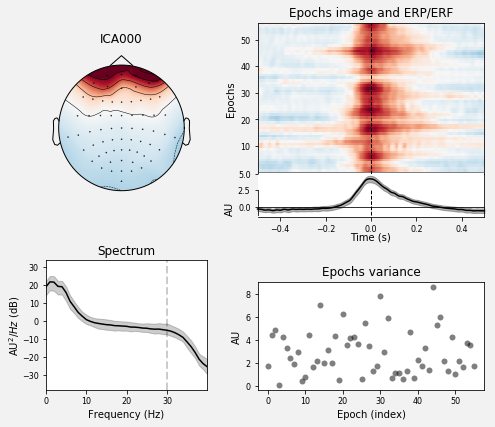

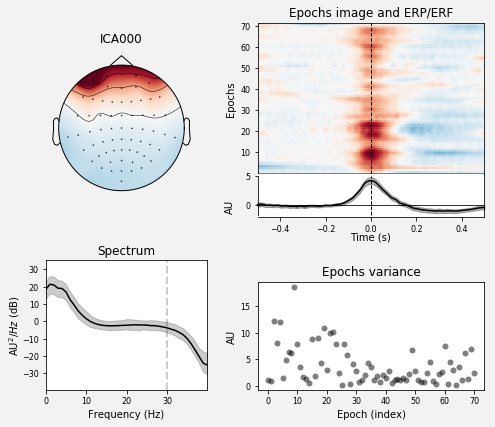

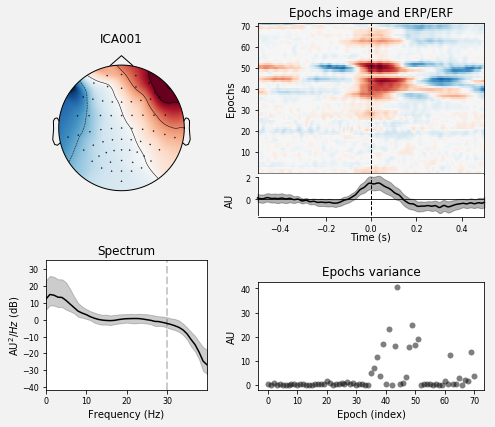

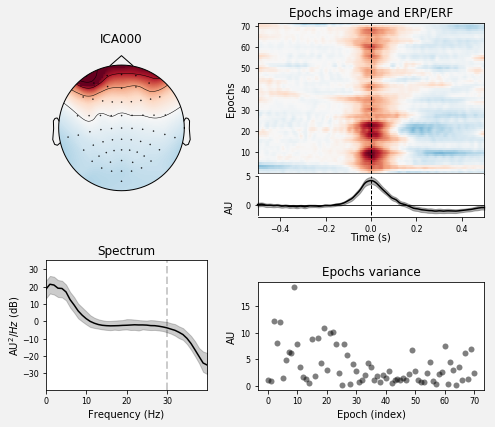

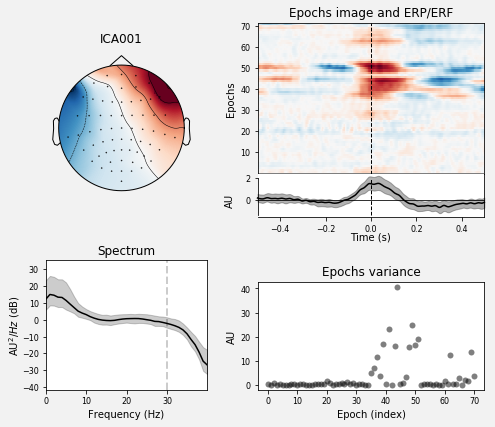

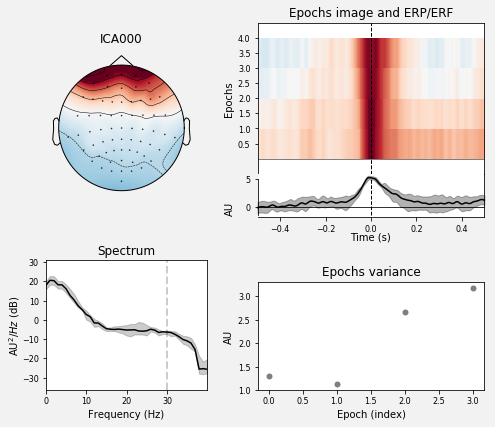

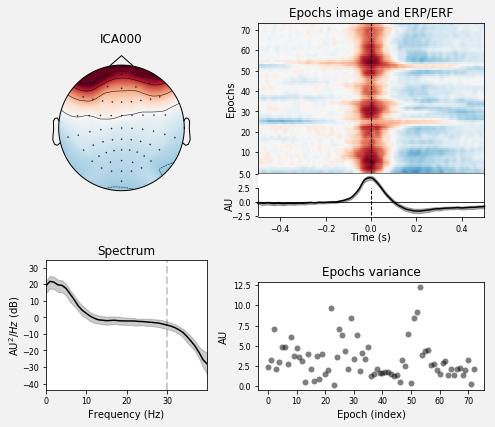

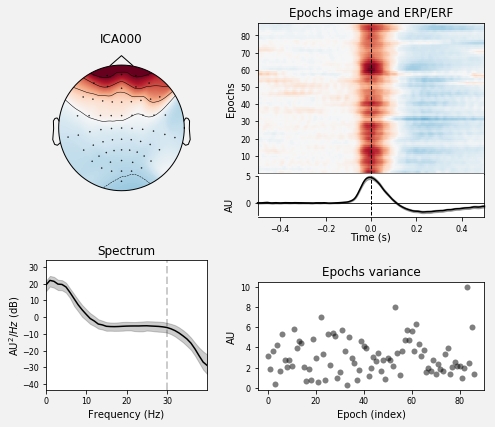

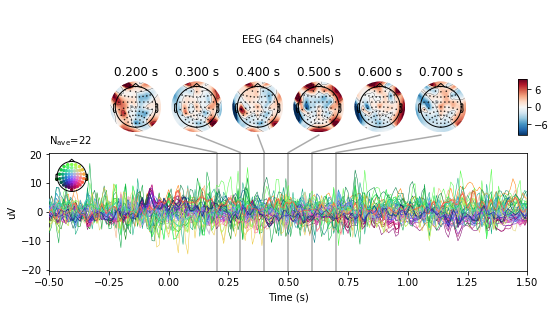

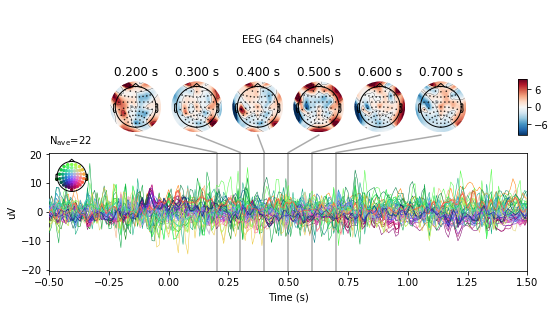

In [95]:
plt.close()
ts_args = dict(xlim=[-.5, 1.5])
all_epochs_hands[4].average().plot_joint(times=[.2, .3, .4, .5, .6, .7], ts_args=ts_args)

In [96]:
ind_erps_hands = [all_epochs_hands[i].average() for i in range(0, len(all_epochs_hands))]
ind_erps_hands

[<Evoked  |  'hands' (mean, N=21), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'hands' (mean, N=24), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'hands' (mean, N=21), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'hands' (mean, N=23), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'hands' (mean, N=22), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'hands' (mean, N=22), [-1, 3.99] sec, 64 ch, ~415 kB>]

In [97]:
ind_erps_feet = [all_epochs_feet[i].average() for i in range(0, len(all_epochs_feet))]
ind_erps_feet

[<Evoked  |  'feet' (mean, N=24), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'feet' (mean, N=21), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'feet' (mean, N=24), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'feet' (mean, N=22), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'feet' (mean, N=23), [-1, 3.99] sec, 64 ch, ~415 kB>,
 <Evoked  |  'feet' (mean, N=23), [-1, 3.99] sec, 64 ch, ~415 kB>]

Identifying common channels ...
all channels are corresponding, nothing to do.


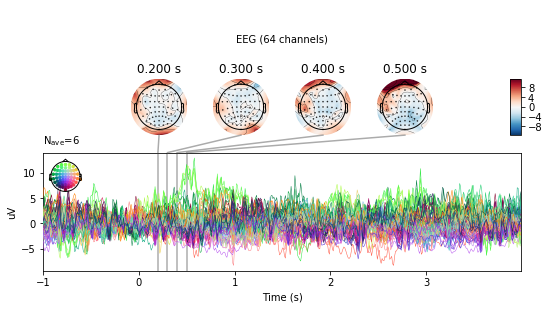

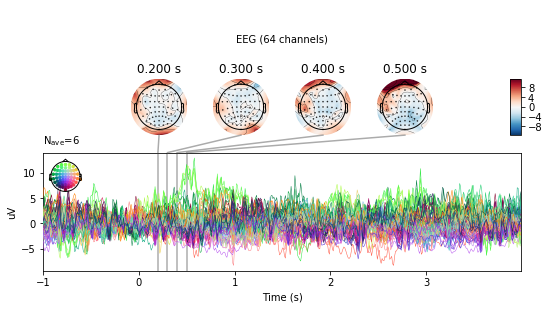

In [98]:
plt.close()
ga_hands = mne.grand_average(ind_erps_hands)
ga_hands.plot_joint(times=[.2, .3, .4, .5])

Identifying common channels ...
all channels are corresponding, nothing to do.


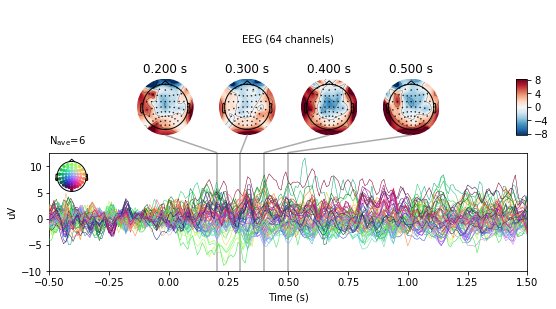

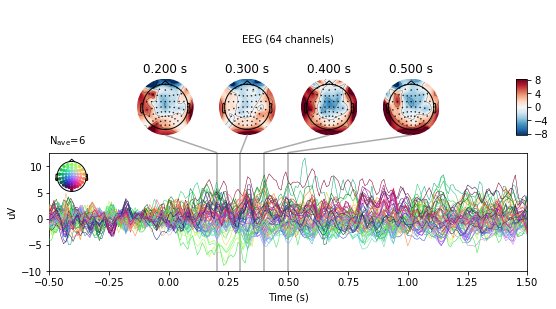

In [99]:
plt.close()
ts_args = dict(xlim=[-.5, 1.5])
ga_feet = mne.grand_average(ind_erps_feet)
ga_feet.plot_joint(times=[.2, .3, .4, .5], ts_args=ts_args)